## 5- Next Best Action

Now, we have our models that allows us to compute needs'prediction for a client. The final step is to create a simple recommandation system for the seller, which use our models to detect a need or a not need of a client and then recommend to him the next best action. To do it, we will:
- Predict the client need (Accumulation, Investment, both or none)
- Match the prediction with the product type (if we do not have a need, we stop here)
- Match the product risk with the client risk
- Propose a list of products

So let us start.

In [1]:
#Classical libraries
import pandas as pd
import seaborn as sns

#Our functions
%cd ..
from src.nbaFnct import *

/home/emmalito/Bureau/Ensimag/S8_Milan/Fintech/ML_BC2


2022-06-07 21:44:38.474488: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-07 21:44:38.474557: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


First, we have to import the products dataset and the clients dataset to visualize them with some plots. 

In [3]:
# Restore the dataset
%store -r dataset

[Text(0.5, 1.0, 'RiskPropensity for client with Income need')]

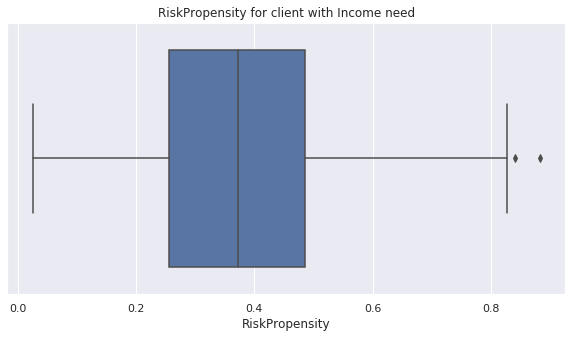

In [7]:
riskIncomeClient = dataset[(dataset.values[:,5]==1)]["RiskPropensity"] #Positive Income target
sns.set(rc = {'figure.figsize':(10,5)})
sns.boxplot(x=riskIncomeClient).set(title="RiskPropensity for client with Income need")

Here is the box plot of risk propensity for clients who have an income need. It is a normalised score, from 0 to 1, which evaluate the client risk. The minimum level of risk is 0.02 and the maximum is 0.88.

We have 50% of client risk which are between 0.25 and 0.48 with the median at 0.37.

We can also see that we have two outliers datas, include the maximum risk at 0.88.

[Text(0.5, 1.0, 'RiskPropensity for client with Accumulation need')]

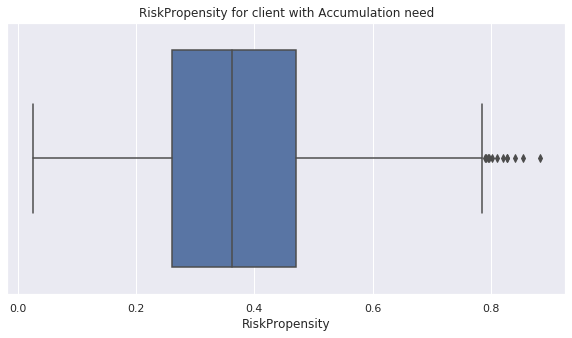

In [8]:
riskAccumulationClient = dataset[(dataset.values[:,6]==1)]["RiskPropensity"] #Positive Accumulation target
sns.set(rc = {'figure.figsize':(10,5)})
sns.boxplot(x=riskAccumulationClient).set(title="RiskPropensity for client with Accumulation need")

Here is the box plot of risk propensity for client who have accumulation need. Again, the minimum value is 2% and the maximum is 88%. We also have some extrem values a bit before 80%.

According to the box plot, 50% of the risk scores is between 26 and 47% with a median at 36%.

Now, let us see the histogram of the risk propensity. 

[Text(0.5, 1.0, 'Histogram of riskPropensity for Income target distribution')]

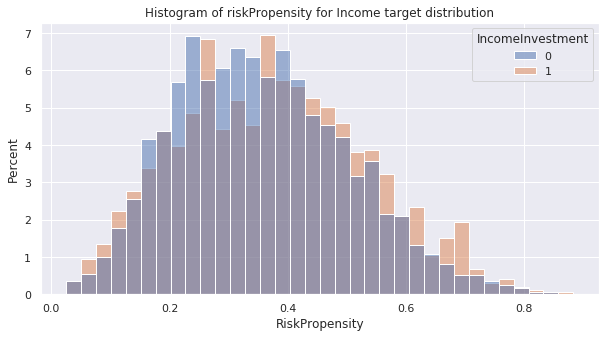

In [9]:
# Histogram of RiskPropensity by IncomeInvestment
sns.set(rc = {'figure.figsize':(10,5)})
sns.histplot(x="RiskPropensity", data=dataset, hue="IncomeInvestment", stat="percent", common_norm=False).set(title="Histogram of RiskPropensity for Income target distribution")

This grah is the histogram of the feature **RiskPropensity** for positive (in orange) and negative (in blue) target *IncomeInvestment* normalized in percentage.

We can see that globaly, the distribution for positive and negative target are quite similar.

For the lower risk (under 0.2) the distribution for the positive target is a little bit superior (except for one case) but positive and negative target follow the same dynamic. 

For the risk between 0.2 and 0.4, the distribution for negative target are more higher. For the risk above 0.4, the distribution of positive target is superior, especially for some value.

[Text(0.5, 1.0, 'Histogram of RiskPropensity for Accumulation target distribution')]

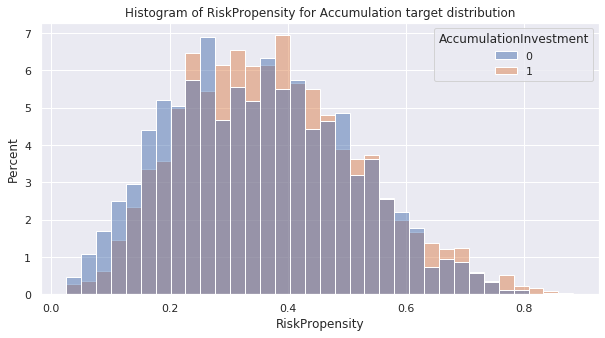

In [10]:
# Histogram of RiskPropensity by AccumulationInvestment
sns.set(rc = {'figure.figsize':(10,5)})
sns.histplot(x="RiskPropensity", data=dataset, hue="AccumulationInvestment", stat="percent", common_norm=False).set(title="Histogram of RiskPropensity for Accumulation target distribution")

Here again, this grah is the histogram of the feature **RiskPropensity** for positive and negative target *AccumulationInvestment* normalize in percentage.

For the risk under 0.2, the distribution of negative target is superior than the positive one. The dynamic for the negative ones is superior than the positive one.

For the risk between 0.2 and 0.5, the distribution of positive target take the lead and the dynamics is completly different.

Then, for the risk above 0.5, the dynamics of positive and negative target distribution are similar and also the distribution.

Now, we will analyse the dataset of the different products.

In [33]:
# Dataset of the product
xls = pd.ExcelFile('src/Needs.xls')
productsData = pd.read_excel(xls, 'Products', index_col=0)
# Income and Accumulation products dataset
ProductInc = productsData[productsData["Type"]==1].sort_values(by=['Risk'], ascending=False)
ProductAcc = productsData[productsData["Type"]==0].sort_values(by=['Risk'], ascending=False)

In [34]:
print(ProductAcc)

           Type  Risk
IDProduct            
4             0  0.44
2             0  0.30
10            0  0.13
3             0  0.12


This is the dataset of accumulation products (type = 0). It has only 4 products and we can see that the risk is not so high, the maximum is 0.44.

With this level of risk, we can imagine that each client will have a product which can respect their risk propensity.

Two product, id 3 and 10, have a similar risk (0.12 and 0.13). We will have to take into account for the recommandation.

In [35]:
print(ProductInc)

           Type  Risk
IDProduct            
11            1  0.88
7             1  0.75
1             1  0.55
8             1  0.48
5             1  0.41
6             1  0.36
9             1  0.27


This is the dataset of income products (type = 1). It has 7 products, more than the accumulation one. The risks go from 0.27 to 0.88.

We can see that the risk level is more higher (more than 25% of the clients have a risk propensity bellow 0.27!).

We know that 75% of clients with an income need have a risk propensity under 0.48. Here, we have 3 products above this threshold.

We also know that the maximum risk propensity is a little bit higher than 0.88 and here we have a product with a risk at 0.88.

We will have to take into account these observations for the Income recommandation system.

### Recommandation System

Now that we saw the datas, we will build our recommandation system. The idea is to predict a need of a client and then 

In [ ]:
#Load the model
%store -r modIncome
%store -r modAccumulation

#Load the mean and std
%store -r data_mean
%store -r data_std

In [34]:
#Let create a fake sample
age = 63; RatioFeature = 1.2435; logIncome = 5.113; logWealth = 6.00345
data = [age, RatioFeature, logIncome, logWealth]
print(incomePred(data_mean, data_std, modIncome, data))
print(accumulationPred(data_mean, data_std, modIncome, data))

[ True]
[ True]


In [ ]:
NBA(0.10, Product_acc)

In [ ]:
NBA(0.10, Product_acc)